    Author: DANIEL TWENEBOAH ANYIMADU

# Enhancing Multiclass Skin Lesion Classification: A Deep Learning vs. Hybrid Deep Learning-Machine Learning Comparison

**-**    Skin cancer remains a global health concern despite significant advances regarding its treatment modalities.

**-**    Early diagnosis is required to alleviate the increasing incidence and associated morbidity and mortality rates.

**-**    Here, we leverage pure Deep Learning (DL) and hybrid Deep Learning (DL) - Machine Learning (ML) techniques by comparing these two approaches, while enhancing multiclass skin lesion classification.

**NB: Pure Deep Learning (DL) Approach Using ISIC-2017 Dataset**

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
import random

# Libraries for data preprocessing, augmentation and data generators
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for feature extraction and classification using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

# Libraries for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix, plot_confusion_matrix, auc, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling Groundtruth:**

    Loading and visualizing the groundtruth (labels) from a csv file

In [2]:
# Define file path
dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_2_(ITALY)/Machine_and_Deep_Learning/PROJECT/"             # Set path to directory
groundtruth_path = os.path.join(dir_path, "Skin Lesion Classification/Data/ISIC-2017_Training_Part3_GroundTruth.csv") # Set path to groundtruth

# Load groundtruth data to a dataframe
groundtruth_df = pd.read_csv(groundtruth_path)
groundtruth_df.head() # Visualize the first 5 rows of the groundtruth data

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


    Create a new column for "benign" class

In [3]:
groundtruth_df["benign"] = ((groundtruth_df["melanoma"] == 0) & (groundtruth_df["seborrheic_keratosis"] == 0)).astype(int)
groundtruth_df.head()

,image_id,melanoma,seborrheic_keratosis,benign
0,ISIC_0000000,0.0,0.0,1
1,ISIC_0000001,0.0,0.0,1
2,ISIC_0000002,1.0,0.0,0
3,ISIC_0000003,0.0,0.0,1
4,ISIC_0000004,1.0,0.0,0


    Class distribution of "melanoma", "seborrheic_keratosis", "benign"

In [4]:
mel_cd = groundtruth_df["melanoma"].value_counts(); print("Number of melanoma cases: ", mel_cd[1])
sk_cd = groundtruth_df["seborrheic_keratosis"].value_counts(); print("Number of seborrheic keratosis cases: ", sk_cd[1])
ben_cd = groundtruth_df["benign"].value_counts(); print("Number of benign cases: ", ben_cd[1])

print("Total number of cases: ", mel_cd[1] + sk_cd[1] + ben_cd[1])

Number of melanoma cases:  374
Number of seborrheic keratosis cases:  254
Number of benign cases:  1372
Total number of cases:  2000


    Plot a bar graph of the class distribution

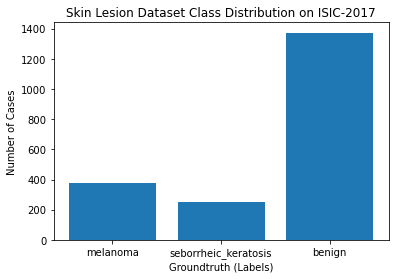

In [5]:
fig, axs = plt.subplots()
axs.bar(["melanoma", "seborrheic_keratosis", "benign"], [mel_cd[1], sk_cd[1], ben_cd[1]])
plt.title("Skin Lesion Dataset Class Distribution on ISIC-2017"); plt.xlabel("Groundtruth (Labels)"); plt.ylabel("Number of Cases")
plt.show()

**Handling Training Dataset (ISIC-2017):**

    Mapping "ISIC-2017_Training_Data" to "image_id"

In [6]:
# Get a list of image path using glob and then create a dictionary to map image file to "image_id"
image_path = glob(os.path.join(dir_path, "ISIC-2017_Training_Data/*.jpg")) # Set path to image directory
image_file = {os.path.splitext(os.path.basename(path))[0] :path for path in image_path}

# Add image file column to the groundtruth dataframe
groundtruth_df["image_file"] = groundtruth_df["image_id"].map(image_file)
groundtruth_df.head()

,image_id,melanoma,seborrheic_keratosis,benign,image_file
0,ISIC_0000000,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
1,ISIC_0000001,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
2,ISIC_0000002,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
3,ISIC_0000003,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
4,ISIC_0000004,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...


    Visualization of "ISIC-2017_Training_Data"

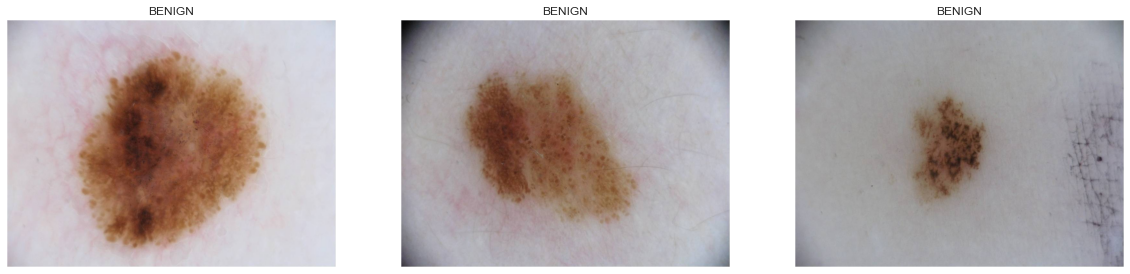

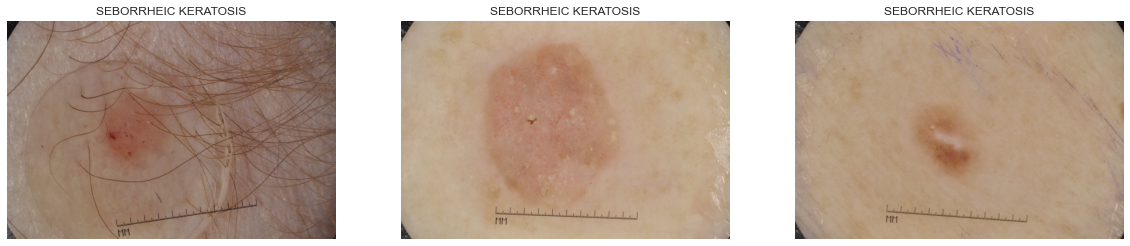

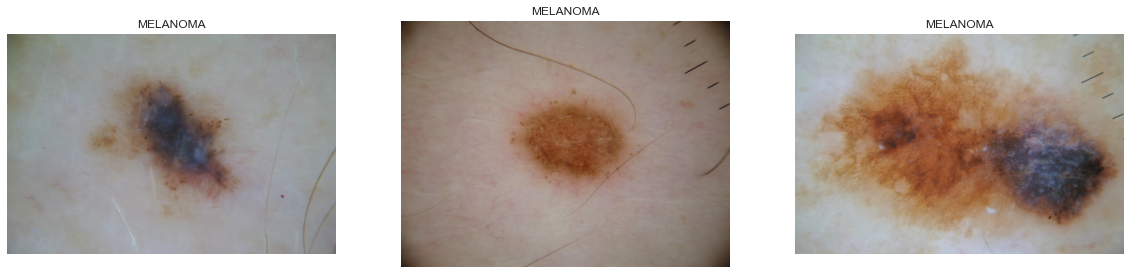

In [7]:
sns.set_style("white")

plt.figure(figsize = [20, 15]) # BENIGN images
for i, image_name in enumerate(groundtruth_df["image_file"][7:10]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("BENIGN")
    
plt.show()


plt.figure(figsize = [20, 15]) # SEBORRHEIC KERATOSIS images
for i, image_name in enumerate(groundtruth_df["image_file"][1090:1093]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("SEBORRHEIC KERATOSIS")
    
plt.show()


plt.figure(figsize = [20, 15]) # MELANOMA images
for i, image_name in enumerate(groundtruth_df["image_file"][461:464]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("MELANOMA")
    
plt.show()

# PERFORM DATA PREPROCESSING AND LABELING

    Combine "melanoma (0)", "seborrheic_keratosis (1)" and "benign (2)" classes to form "mel_seb_ben" class

In [8]:
groundtruth_df["mel_seb_ben"] = np.where(groundtruth_df["melanoma"] == 1, 0, np.where(groundtruth_df["seborrheic_keratosis"] == 1, 1, 2))

# Map "mel_seb_ben" values to their respective labels
labels = {0:"melanoma", 1:"seborrheic_keratosis", 2:"benign"}
groundtruth_df["labels"] = groundtruth_df["mel_seb_ben"].map(labels)

groundtruth_df.head()

,image_id,melanoma,seborrheic_keratosis,benign,image_file,mel_seb_ben,labels
0,ISIC_0000000,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign
1,ISIC_0000001,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign
2,ISIC_0000002,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0,melanoma
3,ISIC_0000003,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign
4,ISIC_0000004,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0,melanoma


    Class distribution of "mel_seb_ben"

In [9]:
msb_counts = groundtruth_df["mel_seb_ben"].value_counts()
print("Total number of instances: ", len(groundtruth_df["mel_seb_ben"])); print(msb_counts)

Total number of instances:  2000
2    1372
0     374
1     254
Name: mel_seb_ben, dtype: int64


    Converting image pixels into a normalized numpy array for further processing

In [10]:
groundtruth_df["image_pixel"] = groundtruth_df["image_file"].map(lambda x: np.asarray(Image.open(x).resize((64, 64))))

# Convert image pixels to numpy array and normalize (0:255) them
image_pixel = np.asarray(groundtruth_df['image_pixel'].tolist())
image_pixel = image_pixel/255

groundtruth_df.head()

,image_id,melanoma,seborrheic_keratosis,benign,image_file,mel_seb_ben,labels,image_pixel
0,ISIC_0000000,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign,"[[[155, 189, 226], [154, 195, 235], [160, 201,..."
1,ISIC_0000001,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign,"[[[142, 141, 149], [144, 141, 148], [152, 150,..."
2,ISIC_0000002,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0,melanoma,"[[[30, 30, 30], [17, 17, 17], [18, 18, 18], [1..."
3,ISIC_0000003,0.0,0.0,1,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2,benign,"[[[225, 224, 229], [222, 222, 224], [221, 221,..."
4,ISIC_0000004,1.0,0.0,0,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0,melanoma,"[[[26, 26, 26], [15, 15, 15], [16, 16, 16], [1..."


#  RESAMPLING AND DATA GENERATORS 
**TASK : PERFORM MULTICLASS CLASSIFICATION**

    Resample the training data: "benign" = , "seborrheic_keratosis" = , "melanoma" = , to ensure same number of samples.

In [11]:
ben_data = groundtruth_df[groundtruth_df["mel_seb_ben"] == 2]
seb_data = groundtruth_df[groundtruth_df["mel_seb_ben"] == 1]
mel_data = groundtruth_df[groundtruth_df["mel_seb_ben"] == 0]

# Given class distribution
ben_cases = 1372; seb_cases = 254; mel_cases = 374

# Calculate the target number of samples for each class (upsampling)
target_samples =  1000 # max(ben_cases, seb_cases, mel_cases)

# Upsampling "seborrheic_keratosis" and "melanoma" and downsample "benign"
ben_downsampled = resample(ben_data, replace = False, n_samples = target_samples, random_state = 42)     # Without replacement
seb_upsampled = resample(seb_data, replace = True, n_samples = target_samples, random_state = 42)        # With replacement
mel_upsampled = resample(mel_data, replace = True, n_samples = target_samples, random_state = 42)        # With replacement

# Shuffle resampled data to avoid any learning bias
resampled_data = pd.concat([ben_downsampled, seb_upsampled, mel_upsampled])
resampled_data = resampled_data.sample(frac = 1, random_state = 42)

    Split the "resampled_data" into: training = 70%, test = 30%

In [12]:
train, test = train_test_split(resampled_data, test_size = 0.3, random_state = 42)

    Runtime augmentation and data generators for training and test data

In [13]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale = 1.0/255)

    Data generator creation for training, validation and test dataset

In [14]:
train_generator = train_datagen.flow_from_dataframe(train, x_col = "image_file", y_col = "labels", target_size = (64, 64), color_mode = "rgb", class_mode = "categorical", batch_size = 32, subset = "training")
validation_generator = train_datagen.flow_from_dataframe(train, x_col = "image_file", y_col = "labels", target_size = (64, 64), color_mode = "rgb", class_mode = "categorical", batch_size = 32, subset = "validation")
test_generator = test_datagen.flow_from_dataframe(test, x_col = "image_file", y_col = "labels", target_size = (64, 64), color_mode = "rgb", class_mode = "categorical", batch_size = 32, shuffle = False)

Found 2449 validated image filenames belonging to 3 classes.
Found 432 validated image filenames belonging to 3 classes.
Found 1235 validated image filenames belonging to 3 classes.


# BUILD CNN BASED DEEP LEARNING MODEL

    CNN model implementation

In [15]:
model = Sequential()

model.add(Conv2D(256, (1, 1), activation = "relu", input_shape = (64, 64, 3))) # First Layer (Input Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = "relu", input_shape = (64, 64, 3))) # Second Layer (Hidden Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (5, 5), activation = "relu", input_shape = (64, 64, 3))) # Third Layer (Output Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(32))
model.add(Dense(3, activation = 'softmax'))

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       1024      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 128)       0

    Training a CNN model with image data

In [16]:
batch_size = 32  # number of samples processed before the model is updated
epochs = 60      # number of complete passes through the training dataset

history = model.fit(train_generator, epochs = epochs, batch_size = batch_size, validation_data = validation_generator, verbose = 2)

score = model.evaluate(test_generator)
print('Test accuracy:', score[1])

Epoch 1/60
77/77 - 307s - loss: 1.1027 - acc: 0.3740 - val_loss: 1.0324 - val_acc: 0.5023 - 307s/epoch - 4s/step
Epoch 2/60
77/77 - 356s - loss: 1.0247 - acc: 0.4626 - val_loss: 0.9957 - val_acc: 0.4907 - 356s/epoch - 5s/step
Epoch 3/60
77/77 - 340s - loss: 0.9649 - acc: 0.5161 - val_loss: 0.9981 - val_acc: 0.4722 - 340s/epoch - 4s/step
Epoch 4/60
77/77 - 304s - loss: 0.9481 - acc: 0.5227 - val_loss: 0.9108 - val_acc: 0.5602 - 304s/epoch - 4s/step
Epoch 5/60
77/77 - 301s - loss: 0.8738 - acc: 0.5745 - val_loss: 0.8653 - val_acc: 0.5625 - 301s/epoch - 4s/step
Epoch 6/60
77/77 - 342s - loss: 0.8709 - acc: 0.5700 - val_loss: 0.8603 - val_acc: 0.5648 - 342s/epoch - 4s/step
Epoch 7/60
77/77 - 318s - loss: 0.8456 - acc: 0.5925 - val_loss: 0.8280 - val_acc: 0.5880 - 318s/epoch - 4s/step
Epoch 8/60
77/77 - 303s - loss: 0.8093 - acc: 0.6117 - val_loss: 0.8081 - val_acc: 0.6134 - 303s/epoch - 4s/step
Epoch 9/60
77/77 - 309s - loss: 0.7767 - acc: 0.6321 - val_loss: 0.7731 - val_acc: 0.6065 - 309s

    Model loss graph

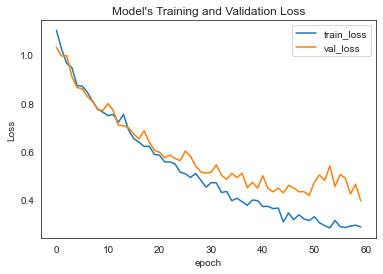

In [17]:
# Plot the training and validation loss at each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training and Validation Loss"); plt.ylabel('Loss'); plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

    Model accuracy graph

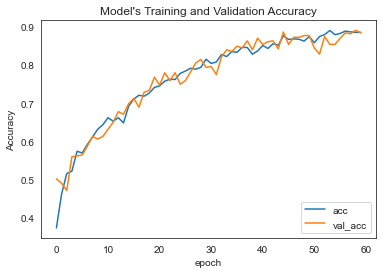

In [18]:
# Plot the training and validation accuracy at each epoch
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model's Training and Validation Accuracy"); plt.ylabel("Accuracy"); plt.xlabel("epoch")
plt.legend(["acc", "val_acc"], loc = "lower right")
plt.show()

# EVALUATION METRICS 

    Make predictions on the test data

In [19]:
pred_acc = model.evaluate(test_generator); print(f"Test accuracy: {pred_acc}")

39/39 [==============================] - 130s 3s/step - loss: 0.6631 - acc: 0.8518
Test accuracy: [0.6630864143371582, 0.8518218398094177]


In [20]:
y_true = test_generator.classes             # Get true labels from the test generator

# Predict probabilities for test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis = 1)  # Convert probabilities to class labels


accuracy = accuracy_score(y_true, y_pred); print("accuracy:", accuracy)                           # Calculate accuracy
precision = precision_score(y_true, y_pred, average = 'weighted'); print("precision:", precision) # Calculate precision
recall = recall_score(y_true, y_pred, average = 'weighted'); print("recall:", recall)             # Calculate recall
f1 = f1_score(y_true, y_pred, average = 'weighted'); print("F1-score:", f1)                       # Calculate F1-score
bma = balanced_accuracy_score(y_true, y_pred); print("Balanced Multiclass Accuracy (BMA):", bma)  # Calculate BMA

39/39 [==============================] - 132s 3s/step
accuracy: 0.8518218623481781
precision: 0.8566248039530693
recall: 0.8518218623481781
F1-score: 0.8479975059915004
Balanced Multiclass Accuracy (BMA): 0.8519776139945222


    Plot confusion matrix

Confusion Matrix:
 [[286  83  45]
 [ 27 364  14]
 [  6   8 402]]


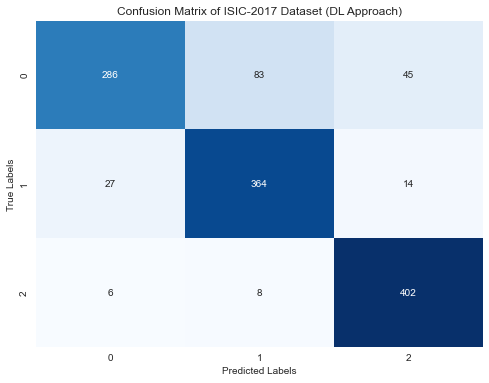

In [21]:
cm = confusion_matrix(y_true, y_pred); print("Confusion Matrix:\n", cm)                           # Calculate confusion matrix

# Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of ISIC-2017 Dataset (DL Approach)')
plt.show()

    Plot ROC curve